# W266 Final Project

Authors: Satheesh Joseph, Catherine Mou, Yi Zhang

*TODO*

- Introduction
- Literature review

## Downloading and loading the data

We acquired the dataset from the researchers in the form of Sqlite `.db` files.

In [36]:
import os, sys, re, json, time, unittest
import itertools, collections
from importlib import reload
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import numpy as np
from scipy import stats
import pandas as pd
import sqlite3
import unicodedata
import nltk

import tensorflow as tf
from sklearn.metrics import classification_report

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [17]:
# Download the files if they're not here
if 'data' not in os.listdir('.') or not os.listdir('data'):
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpHotelData.db -P data/')
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpResData.db -P data/')
    print('Data downloaded successfully!')
else:
    print('Already downloaded data')

Already downloaded data


In [18]:
con = sqlite3.connect('data/yelpResData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

con = sqlite3.connect('data/yelpHotelData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('review',), ('restaurant',), ('reviewer',)]
[('review',), ('sqlite_stat1',), ('sqlite_stat2',), ('reviewer',), ('hotel',)]


In [19]:
# Reading from the hotels database
hotels_db = sqlite3.connect("data/yelpHotelData.db")
hotels = pd.read_sql_query("SELECT * FROM hotel", hotels_db)
hotel_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", hotels_db)
hotel_reviewers = pd.read_sql_query("SELECT * FROM reviewer", hotels_db)


print(f'The data set contains {len(hotels)} hotels, {len(hotel_reviews)} reviews, and {len(hotel_reviewers)} reviewers')

The data set contains 283086 hotels, 5858 reviews, and 5123 reviewers


In [20]:
# Reading from the restaurant database
restaurant_db = sqlite3.connect("data/yelpResData.db")
restaurant_db.text_factory = lambda x: x.decode("utf-8", errors='ignore')
restaurants = pd.read_sql_query("SELECT * FROM restaurant", restaurant_db)
restaurant_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", restaurant_db)
restaurant_reviewers = pd.read_sql_query("SELECT * FROM reviewer", restaurant_db)


print(f'The data set contains {len(restaurants)} restaurants, {len(restaurant_reviews)} reviews, and {len(restaurant_reviewers)} reviewers')

The data set contains 242652 restaurants, 67019 reviews, and 16941 reviewers


# Exploratory Data Analysis

## ToDo: Performan More EDA

In [21]:
hotel_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5858 entries, 0 to 5857
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           5858 non-null   object
 1   reviewID       5858 non-null   object
 2   reviewerID     5858 non-null   object
 3   reviewContent  5858 non-null   object
 4   rating         5858 non-null   int64 
 5   usefulCount    5858 non-null   int64 
 6   coolCount      5858 non-null   int64 
 7   funnyCount     5858 non-null   int64 
 8   flagged        5858 non-null   object
 9   hotelID        5858 non-null   object
dtypes: int64(4), object(6)
memory usage: 457.8+ KB


In [22]:
restaurant_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67019 entries, 0 to 67018
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           67019 non-null  object
 1   reviewID       67019 non-null  object
 2   reviewerID     67019 non-null  object
 3   reviewContent  67019 non-null  object
 4   rating         67019 non-null  int64 
 5   usefulCount    67019 non-null  int64 
 6   coolCount      67019 non-null  int64 
 7   funnyCount     67019 non-null  int64 
 8   flagged        67019 non-null  object
 9   restaurantID   67019 non-null  object
dtypes: int64(4), object(6)
memory usage: 5.1+ MB


In [23]:
reviews = pd.concat([restaurant_reviews, hotel_reviews.rename(columns={'hotelID':'restaurantID'})], ignore_index=True)
reviews.groupby('reviewerID').agg({"usefulCount": np.sum, 
                                   "coolCount": np.sum, 
                                   "funnyCount": np.sum}).sort_values(by=['usefulCount'], ascending=False)
reviews[reviews['reviewerID'] == 'w-w-k-QXosIKQ8HQVwU6IQ']['reviewContent']

94       ***Alinea is truly a one-of-a-kind experience;...
29403    ***Graham Elliot serves up refined casual food...
43054    ***Longman & Eagle is a true gastropub--a casu...
71630    ***While the rooms are small, Hotel Felix is a...
Name: reviewContent, dtype: object

In [24]:
reviews.groupby('flagged').agg('sum')


,rating,usefulCount,coolCount,funnyCount
flagged,,,,
N,252531,65773,42690,36444
Y,34611,0,0,0


,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,restaurantID
rating,,,,,,,,,
1,2444,2444,2444,2444,2444,2444,2444,2444,2444
2,4610,4610,4610,4610,4610,4610,4610,4610,4610
3,9295,9295,9295,9295,9295,9295,9295,9295,9295
4,24243,24243,24243,24243,24243,24243,24243,24243,24243
5,23202,23202,23202,23202,23202,23202,23202,23202,23202


(array([ 2444.,     0.,  4610.,     0.,     0.,  9295.,     0., 24243.,
            0., 23202.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

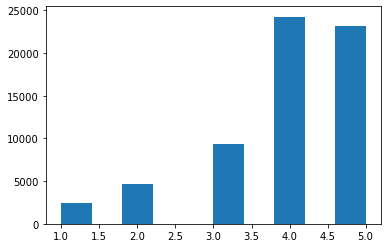

In [57]:
trueReviews = reviews[reviews['flagged'] == 'N']
fakeReviews = reviews[reviews['flagged'] == 'Y']
display(trueReviews.groupby('rating').agg('count'))
plt.hist(x=trueReviews.rating, bins=10)

,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,restaurantID
rating,,,,,,,,,
1,1157,1157,1157,1157,1157,1157,1157,1157,1157
2,719,719,719,719,719,719,719,719,719
3,798,798,798,798,798,798,798,798,798
4,2423,2423,2423,2423,2423,2423,2423,2423,2423
5,3986,3986,3986,3986,3986,3986,3986,3986,3986


(array([1157.,    0.,  719.,    0.,    0.,  798.,    0., 2423.,    0.,
        3986.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

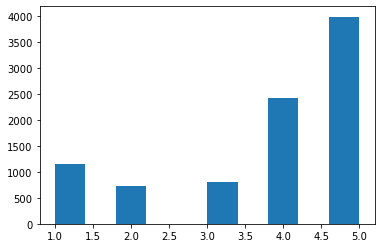

In [58]:
display(fakeReviews.groupby('rating').agg('count'))
plt.hist(x=fakeReviews.rating, bins=10)

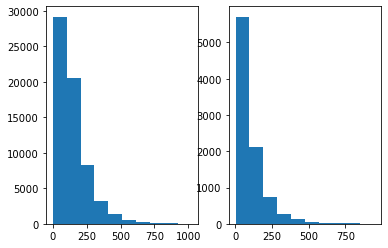

In [107]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count(' ') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count(' ') + 1)
plt.show()

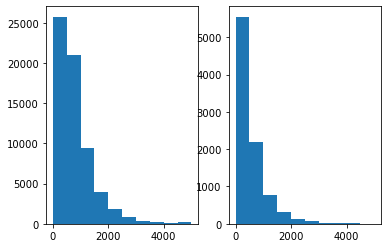

In [106]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count('.') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count('.') + 1)
plt.show()

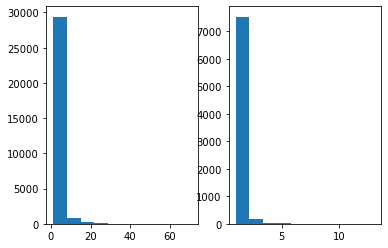

In [137]:
trueReviewerCounts = trueReviews.groupby(['reviewerID']).size().reset_index(name='counts')
fakeReviewerCounts = fakeReviews.groupby(['reviewerID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueReviewerCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviewerCounts['counts'], bins=10)
plt.show()


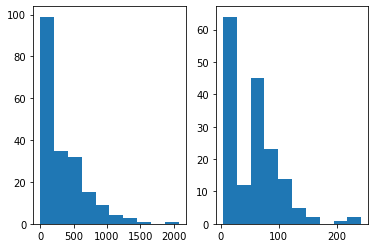

In [136]:
trueRestReviewCounts = trueReviews.groupby(['restaurantID']).size().reset_index(name='counts')
fakeRestReviewCounts = fakeReviews.groupby(['restaurantID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueRestReviewCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeRestReviewCounts['counts'], bins=10)
plt.show()


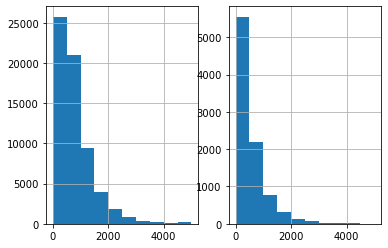

In [139]:
plt.subplot(1, 2, 1)
trueReviews['reviewContent'].str.len().hist()
plt.subplot(1, 2, 2)
fakeReviews['reviewContent'].str.len().hist()
plt.show()




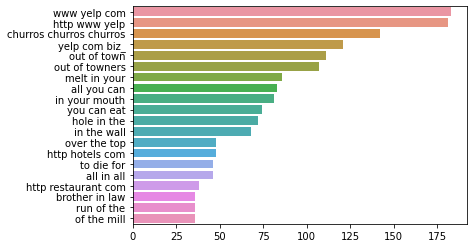

In [197]:

# Code Snippet for Top N-grams Barchart

import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    synthetic = {'gmail', 'they', 'http', 'www'}
    stop=set(stopwords.words('english')) | synthetic
    new= text.str.split()
    new= new.values.tolist()
    corpus=[word for i in new for word in i if word.lower() not in stop]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(corpus,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    

plot_top_ngrams_barchart(trueReviews['reviewContent'],3)

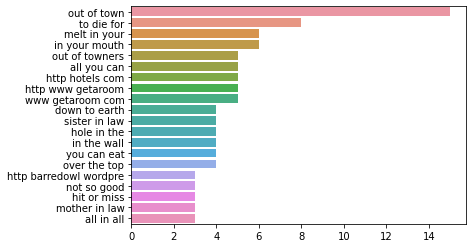

In [198]:
plot_top_ngrams_barchart(fakeReviews['reviewContent'],3)

# Baseline Model

Try a Plain LSTM model on the Hotel data set with fixed length learned embedding

In [25]:
# Some Data Cleaning
hotel_reviews['reviewContent'] = hotel_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))
restaurant_reviews['reviewContent'] = restaurant_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))

In [26]:
# Split train/test data for hotel reviews
X_train, X_test, y_train, y_test = train_test_split(hotel_reviews, hotel_reviews['flagged']=='Y')

In [27]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_train['reviewContent'])
sequences = tokenizer.texts_to_sequences(X_train['reviewContent'])
train_data = pad_sequences(sequences, maxlen=100)

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_test['reviewContent'])
sequences = tokenizer.texts_to_sequences(X_test['reviewContent'])
test_data = pad_sequences(sequences, maxlen=100)


In [28]:
model = Sequential()
model.add(Embedding(20000, 100, input_length=100))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [29]:
model.fit(train_data, y_train, epochs=2)

Epoch 1/2
138/138 [==============================] - 13s 83ms/step - loss: 0.4272 - accuracy: 0.8568
Epoch 2/2
138/138 [==============================] - 12s 85ms/step - loss: 0.3597 - accuracy: 0.8623


In [30]:
y_test

1439    False
2560    False
4250    False
2137    False
4878     True
        ...  
5475    False
791     False
2652    False
1690    False
648     False
Name: flagged, Length: 1465, dtype: bool

In [31]:
y_predicted = model.predict(test_data)

In [32]:
print(classification_report(y_predicted > 0.5, y_test))

              precision    recall  f1-score   support

       False       0.99      0.88      0.93      1456
        True       0.01      0.22      0.02         9

    accuracy                           0.88      1465
   macro avg       0.50      0.55      0.48      1465
weighted avg       0.99      0.88      0.93      1465



# Model 2 - Data Resampling + GloVe embedding

In [33]:
# Download the GloVe embeddings
if 'embedding' not in os.listdir('.') or not os.listdir('embedding'):
    os.system('wget http://nlp.stanford.edu/data/glove.6B.zip -P embedding/')
    os.system('cd embedding && unzip glove.6B.zip')
    print('Data the GloVe embedding successfully!')
else:
    print('Already downloaded the embedding')

Data the GloVe embedding successfully!


In [34]:
# Use the 100 dimensional GloVe embedding
path_to_glove_file = "./embedding/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

FileNotFoundError: [Errno 2] No such file or directory: './embedding/glove.6B.100d.txt'

In [ ]:
# Split the positive/negative samples for more balanced sampling
X_train_positive = X_train[X_train['flagged'] == 'Y']
X_train_negative = X_train[X_train['flagged'] == 'N']

num_samples = 2000
positive_ratio = 0.4
positives = X_train_positive.sample(int(num_samples * positive_ratio), replace=True).reset_index(drop=True)
negatives = X_train_negative.sample(num_samples, replace=True).reset_index(drop=True)

X_train_balanced = pd.concat([positives, negatives], ignore_index=True).sample(frac=1)
y_train_balanced = X_train_balanced['flagged'] == 'Y'

In [ ]:
# First layer, vectorizing the word input
vocabulary_size = 30000
max_tokens = 200

vectorizer = TextVectorization(max_tokens=vocabulary_size, output_sequence_length=max_tokens)
vectorizer.adapt(X_train_balanced['reviewContent'].to_numpy())

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

print(f"Vocabulary size is {len(voc)}")


In [ ]:
# Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
# Build + Lock in the Embedding layer from GloVe
embedding_dim = 100
hits = 0
misses = 0
num_words = len(voc) + 2

# Prepare embedding matrix
# TODO: more pre-processing to avoid ~3000 words that don't have embeddings
embedding_matrix = np.zeros((num_words, embedding_dim))
for i, word in enumerate(voc):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


embedding_layer = Embedding(
    num_words,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


In [ ]:
# Vectorize the input
X_train_ready = vectorizer(X_train_balanced['reviewContent']).numpy()
X_test_ready = vectorizer(X_test['reviewContent']).numpy()

X_train_ready.shape

In [ ]:
# Build and train the model with 
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_ready, y_train_balanced, epochs=8)

In [ ]:
model.evaluate(X_test_ready, y_test)
y_predicted = model.predict(X_test_ready)
print(classification_report(y_predicted > 0.5, y_test))
X_test['flagged'].value_counts() / len(X_test)